In [1]:
# default_exp feature_finding

# Feature Finding

> Functions related to feature finding

This part describes the implementation of the feature-finding algorithm. The core of the algorithm is described in the [MaxQuant-Paper](https://www.nature.com/articles/nbt.1511).
The supplementary material explains the underlying methodology in great detail and is the foundation of the theoretical background that is described here.
A refined version of the algorithm was presented with [Dinosaur](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4933939/), which was also used as a reference for the Python implementation.

For the algorithm, we need serval modules:

1. Connecting Centroids to Hills

2. Refinement of Hills

3. Calculating Hill Statistics

4. Combining Hills to Isotope Patterns

5. Deconvolution of Isotope Patterns

## Loading Data

From the `IO` library, we already have an `*.ms_data.hdf` container that contains centroided data. To use it in feature finding, we directly load the data.

## Connecting Centroids to Hills

> Note: Feature finding relies heavily on the performance function decorator from the performance notebook: `@alphapept.performance.performance_function`. Part of this is that the functions will not have return values to be GPU compatible. Please check out this notebook for further information.

### Connecting centroids

Feature finding starts with connecting centroids. For this we look at subsequent scans and compare peaks that are withing a defined mass tolerance (`centroid_tol`). 

Imagine you have three scans with the following centroids:

* Scan 0: 10, 20, 30
* Scan 1: 10.2, 40.1
* Scan 2: 40, 50, 60

When comparing consecutive scans and defining the maximum delta mass to be 0.5 find the following connections: (Scan No, Centroid No) -> (Scan No, Centroid No). As we cannot easily store tuples in the matrix, we convert tuple containing the position of the connected centroid to an integer.
* (0,0) -> (1,0) -> (3): 10 & 10.2 -> delta = 0.2
* (1,1) -> (2,0) -> (6): 40.1 & 40 -> delta = 0.1

Finally, we store this in the `results` matrix:

$\begin{bmatrix}
3 & -1  & -1 \\ 
-1 & 6 & -1\\ 
-1 & -1 & -1 
\end{bmatrix}$

The coressponding `scores` matrix will look as follows:

$\begin{bmatrix}
0.2 & -1  & -1 \\ 
-1 & 0.1 & -1\\ 
-1 & -1 & -1 
\end{bmatrix}$

This allows us to not only easily store connections between centroids but also perform a quick lookup for the delta of an existing connection. Note that it also only stores the best connection for each centroid. To extract the connected centroids, we can use `np.where(results >= 0)`. This implementation allows getting millions of connections within seconds. 

As we are also allowing gaps, refering to that we can have connections between Scan 0 and Scan 2, we make the aforementioned matrix multdimensional, so that e.g. a first matrix stores the conncetions for no gap, the second matrix the connections with a gap of 1.

The functionality for this step is implemented in `connect_centroids_unidirection` and the wrapper `find_centroid_connections`.

In [2]:
#export
import numpy as np
import alphapept.performance

#This function is tested by being called from find_centroid_connections
@alphapept.performance.performance_function
def connect_centroids_unidirection(x:np.ndarray, row_borders:np.ndarray, connections:np.ndarray, scores:np.ndarray, centroids:np.ndarray, max_gap:int, centroid_tol:float):
    """Connect centroids.

    Args:
        x (np.ndarray): Index to datapoint. Note that this using the performance_function, so one passes an ndarray.
        row_borders (np.ndarray): Row borders of the centroids array.
        connections (np.ndarray): Connections matrix to store the connections
        scores (np.ndarray):  Score matrix to store the connections
        centroids (np.ndarray): 1D Array containing the masses of the centroids data.
        max_gap (int): Maximum gap when connecting centroids.
        centroid_tol (float): Centroid tolerance.
    """
    for gap in range(max_gap + 1):
        y = x + gap + 1
        if y >= row_borders.shape[0]:
            return

        start_index_f = 0
        if x > 0:
            start_index_f = row_borders[x - 1]

        centroids_1 = centroids[start_index_f: row_borders[x]]
        start_index_b = row_borders[y - 1]
        centroids_2 = centroids[start_index_b: row_borders[y]]

        i = 0
        j = 0

        while (i < len(centroids_1)) & (j < len(centroids_2)):
            mz1, mz2 = centroids_1[i], centroids_2[j]
            diff = mz1 - mz2
            mz_sum = mz1 + mz2
            delta = 2 * 1e6 * abs(diff) / mz_sum

            if delta < centroid_tol:
                if scores[x, i, gap] > delta:
                    scores[x, i, gap] = delta
                    connections[x, i, gap] = (connections.shape[1] * y) + j

            if diff > 0:
                j += 1
            else:
                i += 1


def find_centroid_connections(rowwise_peaks:np.ndarray, row_borders:np.ndarray, centroids:np.ndarray, max_gap:int, centroid_tol:float):
    """Wrapper function to call connect_centroids_unidirection

    Args:
        rowwise_peaks (np.ndarray): Length of centroids with respect to the row borders.
        row_borders (np.ndarray): Row borders of the centroids array.
        centroids (np.ndarray): Array containing the centroids data.
        max_gap (int): Maximum gap when connecting centroids.
        centroid_tol (float): Centroid tolerance.
    """
    if alphapept.performance.COMPILATION_MODE == "cuda":
        import cupy
        cupy = cupy
    else:
        import numpy
        cupy = numpy

    max_centroids = int(cupy.max(rowwise_peaks))
    spectra_cnt = len(row_borders) - 1

    connections = cupy.full((spectra_cnt, max_centroids, max_gap + 1), -1, dtype=np.int32)
    score = cupy.full((spectra_cnt, max_centroids, max_gap + 1), np.inf)

    connect_centroids_unidirection(range(len(row_borders)),
                                    row_borders,
                                   connections,
                                   score,
                                   centroids,
                                   max_gap,
                                   centroid_tol)

    score = score[cupy.where(score < np.inf)]

    score_median = cupy.median(score)
    score_std = cupy.std(score)

    del score, max_centroids, spectra_cnt

    c_shape = connections.shape
    from_r, from_c, from_g = cupy.where(connections >= 0)
    to_r = connections[from_r, from_c, from_g] // c_shape[1]
    to_c = connections[from_r, from_c, from_g] - to_r * c_shape[1]

    del connections, from_g

    return from_r, from_c, to_r, to_c, score_median, score_std

In [3]:
#hide
def test_find_centroid_connections():
    row_borders = np.array([3, 6, 9])
    rowwise_peaks = np.array([3, 3, 3])
    max_gap = 2

    score = np.full((3,3, max_gap), np.inf)
    connections = np.full((3,3, max_gap), -1)

    centroids = np.array([10, 20, 30, 10.2, 40.1, 40, 50, 60])
    centroid_tol = 0.5*1e6

    from_r, from_c, to_r, to_c, score_median, score_std = find_centroid_connections(rowwise_peaks, row_borders, centroids, max_gap, centroid_tol)

    assert np.allclose(from_r, np.array([0, 0, 1, 1])) #e.g. 0,0 is connected to 0,1 -> 10 to 10.2
    assert np.allclose(from_c, np.array([0, 2, 1, 2]))
    assert np.allclose(to_r, np.array([1, 1, 2, 2]))
    assert np.allclose(to_c, np.array([0, 1, 0, 0]))

test_find_centroid_connections()

We wrap the centroid connections in the function `connect_centroids`. This function converts the connections into an usable array.

In [4]:
#export

#the performance functions are tested with the wrapper function connect_centroids
@alphapept.performance.performance_function
def convert_connections_to_array(x:np.ndarray, from_r:np.ndarray, from_c:np.ndarray, to_r:np.ndarray, to_c:np.ndarray, row_borders:np.ndarray, out_from_idx:np.ndarray, out_to_idx:np.ndarray):
    """Convert integer indices of a matrix to coordinates.

    Args:
        x (np.ndarray): Input index. Note that we are using the performance function so this is a range.
        from_r (np.ndarray): From array with row coordinates.
        from_c (np.ndarray): From array with column coordinates.
        to_r (np.ndarray): To array with row coordinates. 
        to_c (np.ndarray): To array with column coordinates.
        row_borders (np.ndarray): Row borders (for indexing).
        out_from_idx (np.ndarray): Reporting array: 1D index from.
        out_to_idx (np.ndarray): Reporting array: 1D index to.
    """    
    row = from_r[x]
    col = from_c[x]
    start_index_f = 0
    if row > 0:
        start_index_f = row_borders[row - 1]
    out_from_idx[x] = start_index_f + col

    row = to_r[x]
    col = to_c[x]
    start_index_f = 0
    if row > 0:
        start_index_f = row_borders[row - 1]
    out_to_idx[x] = start_index_f + col

@alphapept.performance.performance_function
def eliminate_overarching_vertex(x:np.ndarray, from_idx:np.ndarray, to_idx:np.ndarray):
    """Eliminate overacrhing vertex.

    Args:
        x (np.ndarray): Input index. Note that we are using the performance function so this is a range.
        from_idx (np.ndarray): From index.
        to_idx (np.ndarray): To index.
    """
    if x == 0:
        return

    if from_idx[x - 1] == from_idx[x]:
        to_idx[x] = -1

def connect_centroids(rowwise_peaks:np.ndarray, row_borders:np.ndarray, centroids:np.ndarray, max_gap:int, centroid_tol:float)-> (np.ndarray, np.ndarray, float, float):
    """Function to connect centroids.

    Args:
        rowwise_peaks (np.ndarray): Indexes for centroids.
        row_borders (np.ndarray): Row borders (for indexing).
        centroids (np.ndarray): Centroid data.
        max_gap: Maximum gap.
        centroid_tol: Centroid tol for matching centroids.
    Returns:
        np.ndarray: From index.
        np.ndarray: To index.
        float: Median score.
        float: Std deviation of the score.
    """    
    if alphapept.performance.COMPILATION_MODE == "cuda":
        import cupy
        cupy = cupy
    else:
        import numpy
        cupy = numpy

    from_r, from_c, to_r, to_c, score_median, score_std = find_centroid_connections(rowwise_peaks,
                                                           row_borders,
                                                           centroids,
                                                           max_gap,
                                                           centroid_tol)

    from_idx = cupy.zeros(len(from_r), np.int32)
    to_idx = cupy.zeros(len(from_r), np.int32)

    convert_connections_to_array(range(len(from_r)),
                                    from_r,
                                 from_c,
                                 to_r,
                                 to_c,
                                 row_borders,
                                 from_idx,
                                 to_idx)

    eliminate_overarching_vertex(range(len(from_idx)), from_idx, to_idx)

    relavent_idx = cupy.where(to_idx >= 0)
    from_idx = cupy.take(from_idx, relavent_idx)[0]
    to_idx = cupy.take(to_idx, relavent_idx)[0]

    del from_r, from_c, to_r, to_c, relavent_idx
    return from_idx, to_idx, score_median, score_std

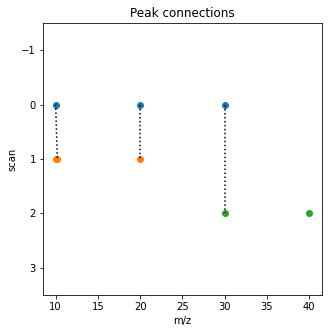

In [5]:
#Sample snippet to show centroid conncetions

import matplotlib.pyplot as plt

row_borders = np.array([3, 6, 9])
rowwise_peaks = np.array([3, 3, 3])
max_gap = 2

score = np.full((3,3, max_gap), np.inf)
connections = np.full((3,3, max_gap), -1)

centroids = np.array([10, 20, 30, 10.2, 20, 10, 30, 40])
centroid_tol = 0.5*1e5

from_idx, to_idx, score_median, score_std = connect_centroids(rowwise_peaks, row_borders, centroids, max_gap, centroid_tol)

scan_no = np.array([0, 0, 0, 1, 1, 2, 2, 2])

plt.figure(figsize=(5,5))
for i, _ in enumerate(row_borders):
    ctrd = centroids[_-rowwise_peaks[i]:_]
    plt.plot(ctrd, np.ones_like(ctrd)*i, 'o')
    
for i, _ in enumerate(from_idx):
    from_ = _
    to_ = to_idx[i]
    plt.plot([centroids[from_], centroids[to_]], [scan_no[from_], scan_no[to_]], 'k:')
    
plt.ylabel('scan')
plt.xlabel('m/z')
plt.ylim(len(row_borders)+0.5, -1.5)
plt.title('Peak connections')
plt.show()

In [6]:
#hide
def test_connect_centroids():
    row_borders = np.array([3, 6, 9])
    rowwise_peaks = np.array([3, 3, 3])
    max_gap = 2

    score = np.full((3,3, max_gap), np.inf)
    connections = np.full((3,3, max_gap), -1)

    centroids = np.array([10, 20, 30, 10.2, 20, 10, 30, 40])
    centroid_tol = 0.5*1e5

    from_idx, to_idx, score_median, score_std = connect_centroids(rowwise_peaks, row_borders, centroids, max_gap, centroid_tol)

    assert np.allclose(from_idx, np.array([0, 1, 2]))
    assert np.allclose(to_idx, np.array([3, 4, 6]))

test_connect_centroids()

### Extracting hills.

To extract hills we extract connected components from the connections.

In [7]:
#export
@alphapept.performance.performance_function
def path_finder(x:np.ndarray, from_idx:np.ndarray, to_idx:np.ndarray, forward:np.ndarray, backward:np.ndarray):
    """Extracts path information and writes to path matrix.

    Args:
        x (np.ndarray): Input index. Note that we are using the performance function so this is a range.
        from_idx (np.ndarray): Array containing from indices.
        to_idx (np.ndarray): Array containing to indices.
        forward (np.ndarray): Array to report forward connection.
        backward (np.ndarray): Array to report backward connection.
    """

    fr = from_idx[x]
    to =  to_idx[x]

    forward[fr] = to
    backward[to] = fr

@alphapept.performance.performance_function
def find_path_start(x:np.ndarray, forward:np.ndarray, backward:np.ndarray, path_starts:np.ndarray):
    """Function to find the start of a path.

    Args:
        x (np.ndarray): Input index. Note that we are using the performance function so this is a range.
        forward (np.ndarray):  Array to report forward connection.
        backward (np.ndarray):  Array to report backward connection.
        path_starts (np.ndarray): Array to report path starts.
    """
    if forward[x] > -1 and backward[x] == -1:
        path_starts[x] = 0

@alphapept.performance.performance_function
def find_path_length(x:np.ndarray, path_starts:np.ndarray, forward:np.ndarray, path_cnt:np.ndarray):
    """Function to extract the length of a path.

    Args:
        x (np.ndarray): Input index. Note that we are using the performance function so this is a range.
        path_starts (np.ndarray): Array that stores the starts of the paths.
        forward (np.ndarray): Array that stores forward information.
        path_cnt (np.ndarray): Reporting array to count the paths.
    """    
    ctr = 1
    idx = path_starts[x]
    while forward[idx] > -1:
        ctr += 1
        idx = forward[idx]
    path_cnt[x] = ctr

@alphapept.performance.performance_function
def fill_path_matrix(x:np.ndarray, path_start:np.ndarray, forwards:np.ndarray, out_hill_data:np.ndarray, out_hill_ptr:np.ndarray):
    """Function to fill the path matrix.

    Args:
        x (np.ndarray): Input index. Note that we are using the performance function so this is a range.
        path_starts (np.ndarray): Array that stores the starts of the paths.
        forwards (np.ndarray): Forward array.
        out_hill_data (np.ndarray): Array containing the indices to hills.
        out_hill_ptr (np.ndarray): Array containing the bounds to out_hill_data.
    """
    path_position = 0
    idx = path_start[x]
    while idx > -1:
        out_hill_data[out_hill_ptr[x] + path_position] = idx
        idx = forwards[idx]
        path_position += 1

def get_hills(centroids:np.ndarray, from_idx:np.ndarray, to_idx:np.ndarray, hill_length_min:int=3)-> (np.ndarray, np.ndarray, int):
    """Function to get hills from centroid connections.

    Args:
        centroids (np.ndarray): 1D Array containing the masses of the centroids.
        from_idx (np.ndarray): From index.
        to_idx (np.ndarray): To index.
        hill_length_min (int): Minimum hill length:

    Returns:
        hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
        hill_data (np.ndarray): Array containing the indices to hills.
        path_node_cnt (int): Number of elements in this path.
    """
    if alphapept.performance.COMPILATION_MODE == "cuda":
        import cupy
        cupy = cupy
    else:
        import numpy
        cupy = numpy

    forward = cupy.full(centroids.shape[0], -1)
    backward = cupy.full(centroids.shape[0], -1)
    path_starts = cupy.full(centroids.shape[0], -1)

    path_finder(range(len(from_idx)), from_idx, to_idx, forward, backward)
    find_path_start(range(len(forward)), forward, backward, path_starts)

    # path_starts will now container the first index of all connected centroids
    path_starts = cupy.where(path_starts == 0)[0]

    path_node_cnt = cupy.full(path_starts.shape[0], -1)
    find_path_length(range(len(path_starts)), path_starts, forward, path_node_cnt)

    relavant_path_node = cupy.where(path_node_cnt >= hill_length_min)[0]
    path_starts = cupy.take(path_starts, relavant_path_node)
    path_node_cnt = cupy.take(path_node_cnt, relavant_path_node)
    del relavant_path_node

    # Generate the hill matix indice ptr data
    hill_ptrs = cupy.empty((path_starts.shape[0] + 1), dtype=cupy.int32)

    hill_ptrs[0] = 0
    hill_ptrs[1:] = path_node_cnt.cumsum()
    hill_data = cupy.empty((int(hill_ptrs[-1])), np.int32)

    fill_path_matrix(range(len(path_starts)), path_starts, forward, hill_data, hill_ptrs)

    del from_idx, to_idx, path_starts, forward, backward
    return hill_ptrs, hill_data, path_node_cnt


def extract_hills(query_data:dict, max_gap:int, centroid_tol:float)-> (np.ndarray, np.ndarray, int, float, float):
    """[summary]

    Args:
        query_data (dict): Data structure containing the query data.
        max_gap (int): Maximum gap when connecting centroids.
        centroid_tol (float): Centroid tolerance.

    Returns:
        hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
        hill_data (np.ndarray): Array containing the indices to hills.
        path_node_cnt (int): Number of elements in this path.
        score_median (float): Median score.
        score_std (float): Std deviation of the score.
    """

    if alphapept.performance.COMPILATION_MODE == "cuda":
        import cupy
        cupy = cupy
    else:
        import numpy
        cupy = numpy

    indices = cupy.array(query_data['indices_ms1'])
    mass_data = cupy.array(query_data['mass_list_ms1'])

    rowwise_peaks = indices[1:] - indices[:-1]
    row_borders = indices[1:]

    from_idx, to_idx, score_median, score_std = connect_centroids(rowwise_peaks, row_borders, mass_data, max_gap, centroid_tol)

    hill_ptrs, hill_data, path_node_cnt = get_hills(mass_data, from_idx, to_idx)

    del mass_data
    del indices

    if cupy.__name__ != 'numpy':
        hill_ptrs = hill_ptrs.get()
        hill_data = hill_data.get()
        path_node_cnt = path_node_cnt.get()

        score_median = score_median.get()
        score_std = score_std.get()

    return hill_ptrs, hill_data, path_node_cnt, score_median, score_std

from numba import njit
@njit
def remove_duplicate_hills(hill_ptrs, hill_data, path_node_cnt):
    """
    Removes hills that share datapoints. Starts from the largest hills.
    
    """
    taken_points = np.zeros(hill_data.max()+1)

    c = 0
    current_idx = 0

    hill_ptrs_new = np.zeros_like(hill_ptrs)
    hill_data_new = np.zeros_like(hill_data)

    for i, _ in enumerate(np.argsort(path_node_cnt)[::-1]):
        s, e = hill_ptrs[_], hill_ptrs[_+1]

        point_idx = hill_data[s:e]

        hill_pts = taken_points[point_idx]

        if hill_pts.sum() == 0:
            hill_data_new[current_idx:current_idx+len(hill_pts)] = point_idx
            current_idx += len(hill_pts) 
            hill_ptrs_new[c+1] = current_idx
            c +=1

        taken_points[point_idx] +=1

    hill_data_new = hill_data_new[:current_idx]
    hill_ptrs_new = hill_ptrs_new[:c]

    return hill_ptrs_new, hill_data_new

### Hill Splitting
When having a hill with two or more maxima, we would like to split it at the minimum position. For this, we use a recursive approach. First, the minimum of a hill is detected. A hill is split at this minimum if the smaller of the surrounding maxima is at least the factor `hill_split_level` larger than the minimum. For each split, the process is repeated.

In [8]:
#export
@alphapept.performance.compile_function(compilation_mode="numba")
def fast_minima(y:np.ndarray)->np.ndarray:
    """Function to calculate the local minimas of an array.

    Args:
        y (np.ndarray): Input array.

    Returns:
        np.ndarray: Array containing minima positions.
    """
    minima = np.zeros(len(y))

    start = 0
    end = len(y)

    for i in range(start + 2, end - 2):
        if ((y[i - 1] > y[i]) & (y[i + 1] > y[i])) \
            or ((y[i - 1] > y[i]) & (y[i + 1] == y[i]) & (y[i + 2] > y[i])) \
            or ((y[i - 2] > y[i]) & (y[i - 1] == y[i]) & (y[i + 1] > y[i])) \
            or (((y[i - 2] > y[i]) & (y[i - 1] == y[i]) & (y[i + 1] == y[i]) & \
                (y[i + 2] > y[i]))):
            minima[i] = 1

    minima = minima.nonzero()[0]

    return minima

In [9]:
#hide
def test_fast_minima():
    assert fast_minima(np.array([3,2,1,0,1,2,3])) == 3
    assert fast_minima(np.array([4,3,2,1,0,1,2])) == 4
    assert len(fast_minima(np.array([5,4,3,2,1,0,1]))) == 0
    assert len(fast_minima(np.array([6,5,4,3,2,1,0]))) == 0

test_fast_minima()

In [10]:
#export

@alphapept.performance.performance_function(compilation_mode="numba-multithread")
def split(k:np.ndarray, hill_ptrs:np.ndarray, int_data:np.ndarray, hill_data:np.ndarray, splits:np.ndarray, hill_split_level:float, window:int):
    """Function to split hills.

    Args:
        k (np.ndarray): Input index. Note that we are using the performance function so this is a range.
        hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
        int_data (np.ndarray): Array containing the intensity to each centroid.
        hill_data (np.ndarray): Array containing the indices to hills.
        splits (np.ndarray): Array containing splits.
        hill_split_level (float): Split level for hills.
        window (int): Smoothing window.
    """

    start = hill_ptrs[k]
    end = hill_ptrs[k + 1]

    int_idx = hill_data[start:end] #index to hill data

    int_trace = int_data[int_idx]

    for i in range(len(int_idx)):
        min_index = max(0, i - window)
        max_index = min(len(int_idx), i + window + 1)
        int_trace[i] = np.median(int_trace[min_index:max_index])

    for i in range(len(int_idx)):
        min_index = max(0, i - window)
        max_index = min(len(int_idx), i + window + 1)
        int_trace[i] = np.mean(int_trace[min_index:max_index])

    #minima = (np.diff(np.sign(np.diff(int_trace))) > 0).nonzero()[0] + 1 #This works also but is slower

    minima = fast_minima(int_trace)

    sorted_minima = np.argsort(int_trace[minima])

    minima = minima[sorted_minima]

    for min_ in minima:

        minval = int_trace[min_]

        left_max = max(int_trace[:min_])
        right_max = max(int_trace[min_:])

        min_max = min(left_max, right_max)

        if (minval == 0) or ((min_max / minval) > hill_split_level):
            splits[k] = start+min_
            break # Split only once per iteration

def split_hills(hill_ptrs:np.ndarray, hill_data:np.ndarray, int_data:np.ndarray, hill_split_level:float, window:int)->np.ndarray:
    """Wrapper function to split hills

    Args:
        hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
        hill_data (np.ndarray): Array containing the indices to hills.
        int_data (np.ndarray): Array containing the intensity to each centroid.
        hill_split_level (float): Split level for hills.
        window (int): Smoothing window.

    Returns:
        np.ndarray: Array containing the bounds to the hill_data with splits.
    """

    splits = np.zeros(len(int_data), dtype=np.int32)
    to_check = np.arange(len(hill_ptrs)-1)

    while len(to_check) > 0:
        split(to_check, hill_ptrs, int_data, hill_data, splits, hill_split_level, window)
        splitpoints = splits.nonzero()[0]

        to_check = np.zeros(len(hill_ptrs))
        to_check[splitpoints] = 1

        to_check = np.insert(to_check, splitpoints+1, np.ones(len(splitpoints))).nonzero()[0] #array, index, what
        hill_ptrs = np.insert(hill_ptrs, splitpoints+1, splits[splitpoints]) #array, index, what

        splits = np.zeros(len(hill_ptrs), dtype=np.int32) #was cupy np.int32

    return hill_ptrs

### Filter Hills

To filter hills, we define a minimum length `hill_min_length`. All peaks below the threshold `hill_peak_min_length` are accepted as is. For longer hills, the intensity at the start and the end are compared to the maximum intensity. If the ratio of the maximum raw intensity to the smoothed intensity and the beginning and end are larger than `hill_peak_factor` the hills are accepted.

In [11]:
#export
@alphapept.performance.performance_function(compilation_mode="numba-multithread")
def check_large_hills(idx:np.ndarray, large_peaks:np.ndarray, hill_ptrs:np.ndarray, hill_data:np.ndarray, int_data:np.ndarray, to_remove:np.ndarray, large_peak:int = 40, hill_peak_factor:float = 2, window:int=1):
    """Function to check large hills and flag them for removal.

    Args:
        idx (np.ndarray): Input index. Note that we are using the performance function so this is a range.
        large_peaks (np.ndarray): Array containing large peaks.
        hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
        hill_data (np.ndarray): Array containing the indices to hills.
        int_data (np.ndarray): Array containing the intensity to each centroid.
        to_remove (np.ndarray): Array with indexes to remove.
        large_peak (int, optional): Length criterion when a peak is large. Defaults to 40.
        hill_peak_factor (float, optional): Hill maximum criterion. Defaults to 2.
        window (int, optional): Smoothing window.. Defaults to 1.
    """
    k = large_peaks[idx]

    start = hill_ptrs[k]
    end = hill_ptrs[k + 1]

    int_idx = hill_data[start:end] #index to hill data

    int_smooth_ = int_data[int_idx]

    for i in range(len(int_idx)):
        min_index = max(0, i - window)
        max_index = min(len(int_idx), i + window + 1)
        int_smooth_[i] = np.median(int_smooth_[min_index:max_index])

    for i in range(len(int_idx)):
        min_index = max(0, i - window)
        max_index = min(len(int_idx), i + window + 1)
        int_smooth_[i] = np.mean(int_smooth_[min_index:max_index])

    int_ = int_data[int_idx]

    max_ = np.max(int_)

    if (max_ / int_smooth_[0] > hill_peak_factor) & (max_ / int_smooth_[-1] > hill_peak_factor):
        to_remove[idx] = 0


def filter_hills(hill_data:np.ndarray, hill_ptrs:np.ndarray, int_data:np.ndarray, hill_check_large:int =40, window:int = 1) -> (np.ndarray, np.ndarray):
    """Filters large hills.

    Args:
        hill_data (np.ndarray): Array containing the indices to hills.
        hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
        int_data (np.ndarray): Array containing the intensity to each centroid.
        hill_check_large (int, optional): Length criterion when a hill is considered large.. Defaults to 40.
        window (int, optional): Smoothing window. Defaults to 1.

    Returns:
        np.ndarray: Filtered hill data.
        np.ndarray: Filtered hill points.
    """

    large_peaks = np.where(np.diff(hill_ptrs)>=hill_check_large)[0]

    to_remove = np.ones(len(large_peaks), dtype=np.int32)
    check_large_hills(range(len(large_peaks)), large_peaks, hill_ptrs, hill_data, int_data, to_remove, window)

    idx_ = np.ones(len(hill_data), dtype = np.int32)
    keep = np.ones(len(hill_ptrs)-1, dtype = np.int32)

    to_remove = to_remove.nonzero()[0]

    for _ in to_remove:
        idx_[hill_ptrs[_]:hill_ptrs[_+1]] = 0
        keep[_] = 0

    hill_lens = np.diff(hill_ptrs)
    keep_ = hill_lens[keep.nonzero()[0]]

    hill_data_ = hill_data[idx_.nonzero()[0]]
    hill_ptrs_ = np.empty((len(keep_) + 1), dtype=np.int32)
    hill_ptrs_[0] = 0
    hill_ptrs_[1:] = keep_.cumsum()

    return hill_data_, hill_ptrs_

Since the mass estimate min the equation above is more complicated than just an average of the mj, a standard deviation based estimate of the error would not be appropriate. Therefore we calculate the error as a bootstrap2 estimate over B=150 bootstrap replications


## Calculating Hill Statistics

Next, we calculate summary statistics for the connected centroids. We can obtain a high precision mass estimate for each hill by taking the average of the the masses and weighting this by their intensiteis:

$$
\overline{m} = \frac{\sum_{j=1}^nm_jI_j}{\sum_{j=1}^nI_j}
$$

To estimate the mass error, we calculate the error as a boostrap estimate:
 
$$\Delta \overline{m} = \sqrt{\frac{\sum_{b=1}^{B}(\overline{m}_b - \overline{m} )}{(B-1)}}$$

The calculation of hill statistics for a single hill is implemented in `get_hill_stats`. To calculate the hill stats for a list of hills, we can call the wrapper `get_hill_data`.

In [12]:
#export

@alphapept.performance.performance_function(compilation_mode="numba-multithread")
def hill_stats(idx:np.ndarray, hill_range:np.ndarray, hill_ptrs:np.ndarray, hill_data:np.ndarray, int_data:np.ndarray, mass_data:np.ndarray, rt_:np.ndarray, rt_idx:np.ndarray, stats:np.ndarray, hill_nboot_max:int, hill_nboot:int):
    """Function to calculate hill stats.

    Args:
        idx (np.ndarray): Input index. Note that we are using the performance function so this is a range.
        hill_range (np.ndarray): Hill range.
        hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
        hill_data (np.ndarray): Array containing the indices to hills.
        int_data (np.ndarray): Array containing the intensity to each centroid.
        mass_data (np.ndarray): Array containing mass data.
        rt_ (np.ndarray): Array with retention time information for each scan.
        rt_idx (np.ndarray): Lookup array to match centroid idx to rt.
        stats (np.ndarray): Stats array that contains summary statistics of hills.
        hill_nboot_max (int): Maximum number of bootstrap comparisons.
        hill_nboot (int): Number of bootstrap comparisons
    """    
    np.random.seed(42)

    start = hill_ptrs[idx]
    end = hill_ptrs[idx + 1]

    idx_ = hill_data[start:end]

    int_ = int_data[idx_]
    mz_ = mass_data[idx_]

    int_sum = np.sum(int_)
    int_area = np.abs(np.trapz(rt_[rt_idx[idx_]], int_)) #Area

    rt_min = rt_[rt_idx[idx_]].min()
    rt_max = rt_[rt_idx[idx_]].max()

    if len(idx_) > hill_nboot_max:
        bootsize = hill_nboot_max
    else:
        bootsize = len(idx_)

    averages = np.zeros(hill_nboot)
    average = 0

    for i in range(hill_nboot):
        boot = np.random.choice(len(int_), bootsize, replace=True)
        boot_mz = np.sum((mz_[boot] * int_[boot])) / np.sum(int_[boot])
        averages[i] = boot_mz
        average += boot_mz

    average_mz = average/hill_nboot

    delta = 0
    for i in range(hill_nboot):
        delta += (average_mz - averages[i]) ** 2 #maybe easier?
    delta_m = np.sqrt(delta / (hill_nboot - 1))

    stats[idx,0] = average_mz
    stats[idx,1] = delta_m
    stats[idx,2] = int_sum
    stats[idx,3] = int_area
    stats[idx,4] = rt_min
    stats[idx,5] = rt_max

def remove_duplicates(stats:np.ndarray, hill_data:np.ndarray, hill_ptrs:np.ndarray)-> (np.ndarray, np.ndarray, np.ndarray):
    """Remove duplicate hills.

    Args:
        stats (np.ndarray): Stats array that contains summary statistics of hills.
        hill_data (np.ndarray): Array containing the indices to hills.
        hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.

    Returns:
        np.ndarray: Filtered hill data.
        np.ndarray: Filtered hill points.
        np.ndarray: Filtered hill stats.
    """

    dups = pd.DataFrame(stats).duplicated() #all duplicated hills

    idx_ = np.ones(len(hill_data), dtype = np.int32) #keep all
    keep = np.ones(len(hill_ptrs)-1, dtype = np.int32)

    for _ in np.arange(len(stats))[dups]: #duplicates will be assigned zeros
        idx_[hill_ptrs[_]:hill_ptrs[_+1]] = 0
        keep[_] = 0

    hill_lens = np.diff(hill_ptrs)
    keep_ = hill_lens[keep.nonzero()[0]]

    hill_data_ = hill_data[idx_.nonzero()[0]]
    hill_ptrs_ = np.empty((len(keep_) + 1), dtype=np.int32)
    hill_ptrs_[0] = 0
    hill_ptrs_[1:] = keep_.cumsum()

    return hill_data_, hill_ptrs_, stats[~dups]

def get_hill_data(query_data:dict, hill_ptrs:np.ndarray, hill_data:np.ndarray, hill_nboot_max:int = 300, hill_nboot:int = 150) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """Wrapper function to get the hill data.

    Args:
        query_data (dict): Data structure containing the query data.
        hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
        hill_data (np.ndarray): Array containing the indices to hills.
        hill_nboot_max (int): Maximum number of bootstrap comparisons.
        hill_nboot (int): Number of bootstrap comparisons

    Returns:
        np.ndarray: Hill stats.
        np.ndarray: Sortindex.
        np.ndarray: Upper index.
        np.ndarray: Scan index.
        np.ndarray: Hill data.
        np.ndarray: Hill points.
    """
    indices_ = np.array(query_data['indices_ms1'])
    rt_ = np.array(query_data['rt_list_ms1'])
    mass_data = np.array(query_data['mass_list_ms1'])
    scan_idx = np.searchsorted(indices_, np.arange(len(mass_data)), side='right') - 1
    int_data = np.array(query_data['int_list_ms1'])

    stats = np.zeros((len(hill_ptrs)-1, 6)) #mz, delta, rt_min, rt_max, sum_max
    hill_stats(range(len(hill_ptrs)-1), np.arange(len(hill_ptrs)-1), hill_ptrs, hill_data, int_data, mass_data, rt_, scan_idx, stats, hill_nboot_max, hill_nboot)

    # sort the stats
    sortindex = np.argsort(stats[:,4]) #Sorted by rt_min
    stats = stats[sortindex,:]
    idxs_upper = stats[:,4].searchsorted(stats[:,5], side="right")
    sortindex_ = np.arange(len(sortindex))[sortindex]

    return stats, sortindex_, idxs_upper, scan_idx, hill_data, hill_ptrs

## Combining Hills to Isotope Patterns

After obtaining summary statistics of hills, the next step is to check whether they belong together to form an isotope pattern. For this, we check wheter it is possible that they are neighbors in an isotope pattern, e.g. one having a 12C atom that has been replaced by a 13C version. The detailed criterion for the check is implemented in `check_isotope_pattern` and is as follows:


$$\left | \Delta m-\frac{\Delta M}{z} \right |\leq \sqrt{\left ( \frac{\Delta S}{z}  \right )^{2}+\Delta {m_{1}}^{2} +\Delta {m_{2}}^{2}}$$

The left side contains $\Delta m$, being the delta of the precise mass estimates from the summary statistics and $\Delta M = 1.00286864$, which is the mass difference ebtween the 13C peak and the monoisotopic peak in an averagine molecule of 1500 Da mass divided by the charge $z$.

The right side contains $\Delta S = 0.0109135$, which is the maximum shift that a sulphur atom can cause ($\Delta S = 2m(^{13}C) - 2m(^{12}C) - m(^{34}S) + m(^{32}S)$) and $\Delta {m_{1}}$ and $\Delta {m_{2}}$, which are the bootstrapped mass standard deviations.

In [13]:
#export
from alphapept.constants import mass_dict

DELTA_M = mass_dict['delta_M']
DELTA_S = mass_dict['delta_S']
maximum_offset = DELTA_M + DELTA_S

@alphapept.performance.compile_function(compilation_mode="numba")
def check_isotope_pattern(mass1:float, mass2:float, delta_mass1:float, delta_mass2:float, charge:int, iso_mass_range:int = 5)-> bool:
    """Check if two masses could belong to the same isotope pattern.

    Args:
        mass1 (float): Mass of the first pattern.
        mass2 (float): Mass of the second pattern.
        delta_mass1 (float): Delta mass of the first pattern.
        delta_mass2 (float): Delta mass of the second pattern.
        charge (int): Charge.
        iso_mass_range (int, optional): Mass range. Defaults to 5.

    Returns:
        bool: Flag to see if pattern belongs to the same pattern.
    """
    delta_mass1 = delta_mass1 * iso_mass_range
    delta_mass2 = delta_mass2 * iso_mass_range

    delta_mass = np.abs(mass1 - mass2)

    left_side = np.abs(delta_mass - DELTA_M / charge)
    right_side = np.sqrt((DELTA_S / charge) ** 2 + delta_mass1 ** 2 + delta_mass2 ** 2)

    return left_side <= right_side

In [14]:
#hide
def test_check_isotope_pattern():
    charge = 1

    mass1, delta_mass1 = 100, 0.1
    mass2, delta_mass2 = 101.1, 0.05

    assert check_isotope_pattern(mass1, mass2, delta_mass1, delta_mass2, charge) == True

    mass2, delta_mass2 = 102.1, 0.05

    assert check_isotope_pattern(mass1, mass2, delta_mass1, delta_mass2, charge) == False

test_check_isotope_pattern()

In [15]:
charge = 1

mass1, delta_mass1 = 100, 0.1
mass2, delta_mass2 = 101.1, 0.05

print(check_isotope_pattern(mass1, mass2, delta_mass1, delta_mass2, charge))

mass2, delta_mass2 = 102.1, 0.05

print(check_isotope_pattern(mass1, mass2, delta_mass1, delta_mass2, charge))

True
False


### Cosine Correlation of two hills

An additional criterion that is being checked is that the intensity profiles have sufficient overalp in retention time. This is validated by ensuring that two hills have a cosine correlation of at least 0.6.

$$\frac{\sum_{s=s_{min}}^{s_{max}}I_sJ_s}{\sum_{s=s_{min}}^{s_{max}}I_s^{2} \sum_{s=s_{min}}^{s_{max}}J_s^{2}} \geq 0.6$$

The intensities of two hills are only compared if both have an intensity value in a particular scan. Otherwise, the intensity is set to zero. Additionally, an overlap of at least three elements is required. 

In [16]:
#export

@alphapept.performance.compile_function(compilation_mode="numba")
def correlate(scans_:np.ndarray, scans_2:np.ndarray, int_:np.ndarray, int_2:np.ndarray)->float:
    """Correlate two scans.

    Args:
        scans_ (np.ndarray): Masses of the first scan.
        scans_2 (np.ndarray): Masses of the second scan.
        int_ (np.ndarray): Intensity of the first scan.
        int_2 (np.ndarray): Intensity of the second scan.

    Returns:
        float: Correlation.
    """

    min_one, max_one = scans_[0], scans_[-1]
    min_two, max_two = scans_2[0], scans_2[-1]

    if min_one + 3 > max_two:  # at least an overlap of 3 elements
        corr = 0
    elif min_two + 3 > max_one:
        corr = 0
    else:
        min_s = min(min_one, min_two)
        max_s = max(max_one, max_two)

        int_one_scaled = np.zeros(int(max_s - min_s + 1))
        int_two_scaled = np.zeros(int(max_s - min_s + 1))

        int_one_scaled[scans_ - min_s] = int_
        int_two_scaled[scans_2 - min_s] = int_2

        corr = np.sum(int_one_scaled * int_two_scaled) / np.sqrt(
            np.sum(int_one_scaled ** 2) * np.sum(int_two_scaled ** 2)
        )

    return corr

### Extracting pre-Isotope Patterns

Now having two criteria to check whether hills could, in principle, belong together, we define the wrapper functions `extract_edge` and `get_edges` to extract the connected hills. To minimize the number of comparisons we need to perform, we only compare the hills that overlap in time (i.e., the start of one hill `rt_min` needs to be before the end of the other hill `rt_max`) and are less than the sum of $\Delta M$ and $\Delta S$ apart. 

To extract all hills that belong together, we again rely on the `NetworkX`-package to extract the connected components. 

In [17]:
#export
@alphapept.performance.compile_function(compilation_mode="numba")
def extract_edge(stats:np.ndarray, idxs_upper:np.ndarray, runner:int, max_index:int, maximum_offset:float,  iso_charge_min:int = 1, iso_charge_max:int = 6, iso_mass_range:int=5)->list:
    """Extract edges.

    Args:
        stats (np.ndarray): Stats array that contains summary statistics of hills.
        idxs_upper (np.ndarray): Upper index for comparing.
        runner (int): Index.
        max_index (int): Unused.
        maximum_offset (float): Maximum offset when comparing edges.
        iso_charge_min (int, optional): Minimum isotope charge. Defaults to 1.
        iso_charge_max (int, optional): Maximum isotope charge. Defaults to 6.
        iso_mass_range (float, optional): Mass search range. Defaults to 5.

    Returns:
        list: List of edges. 
    """    
    edges = []

    mass1 = stats[runner, 0]
    delta_mass1 = stats[runner, 1]

    for j in range(runner+1, idxs_upper[runner]):
        mass2 = stats[j, 0]
        if np.abs(mass2 - mass1) <= maximum_offset:
            delta_mass2 = stats[j, 1]
            for charge in range(iso_charge_min, iso_charge_max + 1):
                if check_isotope_pattern(mass1, mass2, delta_mass1, delta_mass2, charge, iso_mass_range):
                    edges.append((runner, j))
                    break

    return edges

@alphapept.performance.performance_function(compilation_mode="numba-multithread")
def edge_correlation(idx:np.ndarray, to_keep:np.ndarray, sortindex_:np.ndarray, pre_edges:np.ndarray, hill_ptrs:np.ndarray, hill_data:np.ndarray, int_data:np.ndarray, scan_idx:np.ndarray, cc_cutoff:float):
    """Correlates two edges and flag them it they should be kept.

    Args:
        idx (np.ndarray): Input index. Note that we are using the performance function so this is a range.
        to_keep (np.ndarray): Array with indices which edges should be kept.
        sortindex_ (np.ndarray): Sortindex to access the hills from stats.
        pre_edges (np.ndarray): Array with pre edges.
        hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
        hill_data (np.ndarray): Array containing the indices to hills.
        int_data (np.ndarray): Array containing the intensity to each centroid.
        scan_idx (np.ndarray): Array containing the scan index for a centroid.
        cc_cutoff (float): Cutoff value for what is considered correlating.
    """
    edge = pre_edges[idx,:]

    y = sortindex_[edge[0]]
    start = hill_ptrs[y]
    end = hill_ptrs[y + 1]
    idx_ = hill_data[start:end]
    int_ = int_data[idx_]
    scans_ = scan_idx[idx_]

    con = sortindex_[edge[1]]
    start = hill_ptrs[con]
    end = hill_ptrs[con + 1]
    idx_2 = hill_data[start:end]
    int_2 = int_data[idx_2]
    scans_2 = scan_idx[idx_2]

    if correlate(scans_, scans_2, int_, int_2) > cc_cutoff:
        to_keep[idx] = 1

In [18]:
#export
import networkx as nx

def get_pre_isotope_patterns(stats:np.ndarray, idxs_upper:np.ndarray, sortindex_:np.ndarray, hill_ptrs:np.ndarray, hill_data:np.ndarray, int_data:np.ndarray, scan_idx:np.ndarray, maximum_offset:float, iso_charge_min:int=1, iso_charge_max:int=6, iso_mass_range:float=5, cc_cutoff:float=0.6)->list:
    """Function to extract pre isotope patterns.

    Args:
        stats (np.ndarray): Stats array that contains summary statistics of hills.
        idxs_upper (np.ndarray): Upper index for comparison.
        sortindex_ (np.ndarray): Sortindex to access the hills from stats.
        hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
        hill_data (np.ndarray): Array containing the indices to hills.
        int_data (np.ndarray): Array containing the intensity to each centroid.
        scan_idx (np.ndarray): Array containing the scan index for a centroid.
        maximum_offset (float): Maximum offset when matching.
        iso_charge_min (int, optional): Minimum isotope charge. Defaults to 1.
        iso_charge_max (int, optional): Maximum isotope charge. Defaults to 6.
        iso_mass_range (float, optional): Mass search range. Defaults to 5.
        cc_cutoff (float, optional): Correlation cutoff. Defaults to 0.6.

    Returns:
        list: List of pre isotope patterns.
    """    
    pre_edges = []

    # Step 1
    for runner in range(len(stats)):
        pre_edges.extend(extract_edge(stats, idxs_upper, runner, idxs_upper[runner], maximum_offset, iso_charge_min, iso_charge_max, iso_mass_range))

    to_keep = np.zeros(len(pre_edges), dtype='int')
    pre_edges = np.array(pre_edges)
    edge_correlation(range(len(to_keep)), to_keep, sortindex_, pre_edges, hill_ptrs, hill_data, int_data, scan_idx, cc_cutoff)
    edges = pre_edges[to_keep.nonzero()]

    G2 = nx.Graph()
    for i in range(len(edges)):
        G2.add_edge(edges[i][0], edges[i][1])

    pre_isotope_patterns = [
        sorted(list(c))
        for c in sorted(nx.connected_components(G2), key=len, reverse=True)
    ]

    return pre_isotope_patterns

### Extracting Isotope Patterns

The extracted pre-isotope patterns may not be consistent because their pair-wise mass differences may not correspond to the same charge. To extract isotope patterns from pre-isotope patterns, we need to ensure that they are consistent for a single charge. 

To do this, we start with the 100 most intense peaks from a pre-isotope pattern to be used as a seed. For each seed and charge we then try to extract the longest consistent isotope pattern. To check wheter a hill is consistent with the seed we employ a modified checking criterion (`check_isotope_pattern_directed`) to be as follows:

$$\left | m-m_j-\frac{j\Delta M}{z} \right |\leq \sqrt{\left ( \frac{\Delta S}{z}  \right )^{2}+\Delta {m}^{2} +\Delta {m_{j}}^{2}}$$

Here $m$ is the mass of a seed peak, and $m_{j}$ refers to a peak relative to the seed. $j$ refers to the peaks to the left or right (negative or positive index) within the pattern. $j$ needs to run over consecutive values so that gaps are not allowed. Besides this consistency check, two hills are also checked to have a cosine correlation of at least 0.6.

Programmatically, this is implemented in `grow_trail` and `grow`. These function uses a recursive approach that adds matching hills to the seed on the left and right side until no more hills can be added.

In [19]:
#export
from numba.typed import List

@alphapept.performance.compile_function(compilation_mode="numba")
def check_isotope_pattern_directed(mass1:float, mass2:float, delta_mass1:float, delta_mass2:float, charge:int, index:int, iso_mass_range:float)->bool:
    """Check if two masses could belong to the same isotope pattern.

    Args:
        mass1 (float): Mass of the first pattern.
        mass2 (float): Mass of the second pattern.
        delta_mass1 (float): Delta mass of the first pattern.
        delta_mass2 (float): Delta mass of the second pattern.
        charge (int): Charge.
        index (int): Index (unused).
        iso_mass_range (float): Isotope mass ranges.
    Returns:
        bool: Flag if two isotope patterns belong together.
    """
    delta_mass1 = delta_mass1 * iso_mass_range
    delta_mass2 = delta_mass2 * iso_mass_range

    left_side = np.abs(mass1 - mass2 - index * DELTA_M / charge)
    right_side = np.sqrt((DELTA_S / charge) ** 2 + delta_mass1 ** 2 + delta_mass2 ** 2)

    return left_side <= right_side


@alphapept.performance.compile_function(compilation_mode="numba")
def grow(trail:List, seed:int, direction:int, relative_pos:int, index:int, stats:np.ndarray, pattern:np.ndarray, charge:int, iso_mass_range:float, sortindex_:np.ndarray, hill_ptrs:np.ndarray, hill_data:np.ndarray, int_data:np.ndarray, scan_idx:np.ndarray, cc_cutoff:float)->List:
    """Grows isotope pattern based on a seed and direction.

    Args:
        trail (List): List of hills belonging to a pattern.
        seed (int): Seed position.
        direction (int): Direction in which to grow the trail
        relative_pos (int): Relative position.
        index (int): Index.
        stats (np.ndarray): Stats array that contains summary statistics of hills.
        pattern (np.ndarray): Isotope pattern.
        charge (int): Charge.
        iso_mass_range (float): Mass range for checking isotope patterns.
        sortindex_ (np.ndarray): Sortindex to access the hills from stats.
        hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
        hill_data (np.ndarray): Array containing the indices to hills.
        int_data (np.ndarray): Array containing the intensity to each centroid.
        scan_idx (np.ndarray): Array containing the scan index for a centroid.
        cc_cutoff (float): Cutoff value for what is considered correlating.

    Returns:
        List: List of hills belonging to a pattern.
    """    
    x = pattern[seed]  # This is the seed
    mass1 = stats[x,0]
    delta_mass1 = stats[x,1]

    k = sortindex_[x]
    start = hill_ptrs[k]
    end = hill_ptrs[k + 1]
    idx_ = hill_data[start:end]
    int_ = int_data[idx_]
    scans_ = scan_idx[idx_]

    growing = True

    while growing:
        if direction == 1:
            if seed + relative_pos == len(pattern):
                growing = False
                break
        else:
            if seed + relative_pos < 0:
                growing = False
                break

        y = pattern[seed + relative_pos]  # This is a reference peak

        l = sortindex_[y]

        mass2 = stats[y,0]
        delta_mass2 = stats[y,1]

        start = hill_ptrs[l]
        end = hill_ptrs[l + 1]
        idx_ = hill_data[start:end]
        int_2 = int_data[idx_]
        scans_2 = scan_idx[idx_]

        if correlate(scans_, scans_2, int_, int_2) > cc_cutoff:
            if check_isotope_pattern_directed(mass1, mass2, delta_mass1, delta_mass2, charge, -direction * index, iso_mass_range):
                if direction == 1:
                    trail.append(y)
                else:
                    trail.insert(0, y)
                index += (
                    1
                )  # Greedy matching: Only one edge for a specific distance, will not affect the following matches

        delta_mass = np.abs(mass1 - mass2)

        if (delta_mass > (DELTA_M+DELTA_S) * index):  # the pattern is sorted so there is a maximum to look back
            break

        relative_pos += direction

    return trail

@alphapept.performance.compile_function(compilation_mode="numba")
def grow_trail(seed:int, pattern:np.ndarray, stats:np.ndarray, charge:int, iso_mass_range:float, sortindex_:np.ndarray, hill_ptrs:np.ndarray, hill_data:np.ndarray, int_data:np.ndarray, scan_idx:np.ndarray, cc_cutoff:float)->List:
    """Wrapper to grow an isotope pattern to the left and right side.

    Args:
        seed (int): Seed position.
        pattern (np.ndarray): Isotope pattern.
        stats (np.ndarray): Stats array that contains summary statistics of hills.
        charge (int): Charge.
        iso_mass_range (float): Mass range for checking isotope patterns.
        sortindex_ (np.ndarray): Sortindex to access the hills from stats.
        hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
        hill_data (np.ndarray): Array containing the indices to hills.
        int_data (np.ndarray): Array containing the intensity to each centroid.
        scan_idx (np.ndarray): Array containing the scan index for a centroid.
        cc_cutoff (float): Cutoff value for what is considered correlating.

    Returns:
        List: Isotope pattern.
    """
    x = pattern[seed]
    trail = List()
    trail.append(x)
    trail = grow(trail, seed, -1, -1, 1, stats, pattern, charge, iso_mass_range, sortindex_, hill_ptrs, hill_data, int_data, scan_idx, cc_cutoff)
    trail = grow(trail, seed, 1, 1, 1, stats, pattern, charge, iso_mass_range, sortindex_, hill_ptrs, hill_data, int_data, scan_idx, cc_cutoff)

    return trail


@alphapept.performance.compile_function(compilation_mode="numba")
def get_trails(seed:int, pattern:np.ndarray, stats:np.ndarray, charge_range:List, iso_mass_range:float, sortindex_:np.ndarray, hill_ptrs:np.ndarray, hill_data:np.ndarray, int_data:np.ndarray, scan_idx:np.ndarray, cc_cutoff:float)->List:
    """Wrapper to extract trails for a given charge range.

    Args:
        seed (int): Seed index.
        pattern (np.ndarray): Pre isotope pattern.
        stats (np.ndarray): Stats array that contains summary statistics of hills.
        charge_range (List): Charge range.
        iso_mass_range (float): Mass range for checking isotope patterns.
        sortindex_ (np.ndarray): Sortindex to access the hills from stats.
        hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
        hill_data (np.ndarray): Array containing the indices to hills.
        int_data (np.ndarray): Array containing the intensity to each centroid.
        scan_idx (np.ndarray): Array containing the scan index for a centroid.
        cc_cutoff (float): Cutoff value for what is considered correlating.

    Returns:
        List: Trail of consistent hills.
    """
    trails = []
    for charge in charge_range:
        trail = grow_trail(seed, pattern, stats, charge, iso_mass_range, sortindex_, hill_ptrs, hill_data, int_data, scan_idx, cc_cutoff)

        trails.append(trail)

    return trails

In [20]:
#export

def plot_pattern(pattern:np.ndarray, sorted_hills:np.ndarray, centroids:np.ndarray, hill_data:np.ndarray):
    """Helper function to plot a pattern.

    Args:
        pattern (np.ndarray): Pre isotope pattern.
        sorted_hills (np.ndarray): Hills, sorted.
        centroids (np.ndarray): 1D Array containing the masses of the centroids.
        hill_data (np.ndarray): Array containing the indices to hills.
    """
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))
    centroid_dtype = [("mz", float), ("int", float), ("scan_no", int), ("rt", float)]

    mzs = []
    rts = []
    ints = []
    for entry in pattern:
        hill = sorted_hills[entry]
        hill_data = np.array([centroids[_[0]][_[1]] for _ in hill], dtype=centroid_dtype)

        int_profile = hill_data["int"]
        ax1.plot(hill_data["rt"], hill_data["int"])
        ax2.scatter(hill_data["rt"], hill_data["mz"], s = hill_data["int"]/5e5 )


    ax1.set_title('Pattern')
    ax1.set_xlabel('RT (min)')
    ax1.set_ylabel('Intensity')

    ax2.set_xlabel('RT (min)')
    ax2.set_ylabel('m/z')

    plt.show()

In [21]:
#export
@alphapept.performance.compile_function(compilation_mode="numba")
def get_minpos(y:np.ndarray, iso_split_level:float)->List:
    """Function to get a list of minima in a trace.
    A minimum is returned if the ratio of lower of the surrounding maxima to the minimum is larger than the splitting factor.

    Args:
        y (np.ndarray): Input array.
        iso_split_level (float): Isotope split level.

    Returns:
        List: List with min positions.
    """
    minima = get_local_minima(y)
    minima_list = List()

    for minpos in minima:

        minval = y[minpos]

        left_max = (y[:minpos]).max()
        right_max = (y[minpos:]).max()

        minimum_max = min(left_max, right_max)

        if minimum_max / minval >= iso_split_level:
            minima_list.append(minpos)

    return minima_list

@alphapept.performance.compile_function(compilation_mode="numba")
def get_local_minima(y:np.ndarray)->List:
    """Function to return all local minima of a array

    Args:
        y (np.ndarray): Input array.

    Returns:
        List: List with indices to minima.
    """
    minima = List()
    for i in range(1, len(y) - 1):
        if is_local_minima(y, i):
            minima.append(i)
    return minima


@alphapept.performance.compile_function(compilation_mode="numba")
def is_local_minima(y:np.ndarray, i:int)->bool:
    """Check if position is a local minima. 

    Args:
        y (np.ndarray): Input array.
        i (int): Position to check.

    Returns:
        bool: Flag if position is minima or not.
    """
    return (y[i - 1] > y[i]) & (y[i + 1] > y[i])


@alphapept.performance.compile_function(compilation_mode="numba")
def truncate(array:np.ndarray, intensity_profile:np.ndarray, seedpos:int, iso_split_level:float)->np.ndarray:
    """Function to truncate an intensity profile around its seedposition.

    Args:
        array (np.ndarray):  Input array.
        intensity_profile (np.ndarray): Intensities for the input array.
        seedpos (int): Seedposition.
        iso_split_level (float): Split level.

    Returns:
        np.ndarray: Truncated array.
    """
    minima = int_list_to_array(get_minpos(intensity_profile, iso_split_level))

    if len(minima) > 0:
        left_minima = minima[minima < seedpos]
        right_minima = minima[minima > seedpos]

        # If the minimum is smaller than the seed
        if len(left_minima) > 0:
            minpos = left_minima[-1]
        else:
            minpos = 0

        if len(right_minima) > 0:
            maxpos = right_minima[0]
        else:
            maxpos = len(array)

        array = array[minpos:maxpos+1]

    return array

In [22]:
#hide
def test_get_minpos():
    """
    Generate an intensity profile with local minima
    Check that the minima are found

    """
    intensity_profile = np.ones(20) * 10

    minima_ref = [3, 7, 10, 17]

    for minimum in minima_ref:
        intensity_profile[minimum] = 1

    minima = get_minpos(intensity_profile, 2)

    minima_list = [_ for _ in minima]

    assert minima_list == minima_ref

test_get_minpos() 

## Isolating Isotope_patterns

The extraction of the longest consistent isotope pattern is implemented in `isolate_isotope_pattern`. Here, three additional checks for an isotope pattern are implemented. 

The first one is `truncate`. Here, one checks the seed position, whether it has a minimum to its left or right side. If a minimum is found, the isotope pattern is cut off at this position.

The second one is a mass filter. If the seed has a mass of smaller than 1000, the intensity maximum is detected, and all smaller masses are discarded. This reflects the averagine distribution for small masses where no minimum on the left side can be found.

The third one is `check_averagine` that relies on `pattern_to_mz` and `cosine_averagine`. It is used to ensure that the extracted isotope pattern has a cosine correlation of the averagine isotope pattern of the same mass of at least 0.6.

After the longest consistent isotope pattern is found, the hills are removed from the pre-isotope pattern, and the process is repeated until no more isotope patterns can be extracted from the pre-isotope patterns.

In [23]:
#export
from alphapept.chem import mass_to_dist
from alphapept.constants import averagine_aa, isotopes, Isotope
from numba.typed import Dict

@alphapept.performance.compile_function(compilation_mode="numba")
def check_averagine(stats:np.ndarray, pattern:np.ndarray, charge:int, averagine_aa:Dict, isotopes:Dict)->float:
    """Function to compare a pattern to an averagine model.

    Args:
        stats (np.ndarray): Stats array that contains summary statistics of hills.
        pattern (np.ndarray): Isotope pattern.
        charge (int): Charge.
        averagine_aa (Dict): Dict containing averagine masses.
        isotopes (Dict): Dict containing isotopes.

    Returns:
        float: Averagine correlation.
    """
    masses, intensity = pattern_to_mz(stats, pattern, charge)

    spec_one = np.floor(masses).astype(np.int64)
    int_one = intensity

    spec_two, int_two = mass_to_dist(np.min(masses), averagine_aa, isotopes) # maybe change to no rounded version

    spec_two = np.floor(spec_two).astype(np.int64)

    return cosine_averagine(int_one, int_two, spec_one, spec_two)

@alphapept.performance.compile_function(compilation_mode="numba")
def pattern_to_mz(stats:np.ndarray, pattern:np.ndarray, charge:int)-> (np.ndarray, np.ndarray):
    """Function to calculate masses and intensities from pattern for a given charge.

    Args:
        stats (np.ndarray): Stats array that contains summary statistics of hills.
        pattern (np.ndarray): Isotope pattern.
        charge (int): Charge of the pattern.

    Returns:
        np.ndarray: masses
        np.ndarray: intensity
    """

    mzs = np.zeros(len(pattern))
    ints = np.zeros(len(pattern))

    for i in range(len(pattern)):
        entry = pattern[i]
        mzs[i] = mz_to_mass(stats[entry,0], charge)
        ints[i] = stats[entry,2]

    sortindex = np.argsort(mzs)

    masses = mzs[sortindex]
    intensity = ints[sortindex]

    return masses, intensity

@alphapept.performance.compile_function(compilation_mode="numba")
def cosine_averagine(int_one:np.ndarray, int_two:np.ndarray, spec_one:np.ndarray, spec_two:np.ndarray)-> float:
    """Calculate the cosine correlation of two hills. 

    Args:
        int_one (np.ndarray): Intensity of the first hill.
        int_two (np.ndarray): Intensity of the second hill.
        spec_one (np.ndarray): Scan numbers of the first hill.
        spec_two (np.ndarray): Scan numbers of the second hill.

    Returns:
        float: Cosine 
    """

    min_one, max_one = spec_one[0], spec_one[-1]
    min_two, max_two = spec_two[0], spec_two[-1]

    min_s = np.min(np.array([min_one, min_two]))
    max_s = np.max(np.array([max_one, max_two]))

    int_one_scaled = np.zeros(int(max_s - min_s + 1))
    int_two_scaled = np.zeros(int(max_s - min_s + 1))

    int_one_scaled[spec_one - min_s] = int_one
    int_two_scaled[spec_two - min_s] = int_two

    corr = np.sum(int_one_scaled * int_two_scaled) / np.sqrt(
        np.sum(int_one_scaled ** 2) * np.sum(int_two_scaled ** 2)
    )

    return corr



@alphapept.performance.compile_function(compilation_mode="numba")
def int_list_to_array(numba_list:List)->np.ndarray:
    """Numba compatbilte function to convert a numba list with integers to a numpy array

    Args:
        numba_list (List): Input numba-typed List.

    Returns:
        np.ndarray: Output numpy array.
    """
    array = np.zeros(len(numba_list), dtype=np.int64)

    for i in range(len(array)):

        array[i] = numba_list[i]

    return array

M_PROTON = mass_dict['Proton']

@alphapept.performance.compile_function(compilation_mode="numba")
def mz_to_mass(mz:float, charge:int)->float:
    """Function to calculate the mass from a mz value.

    Args:
        mz (float): M/z
        charge (int): Charge.

    Raises:
        NotImplementedError: When a negative charge is used.

    Returns:
        float: mass
    """
    if charge < 0:
        raise NotImplementedError("Negative Charges not implemented.")

    mass = mz * charge - charge * M_PROTON

    return mass

In [24]:
#hide

if False:


    def test_truncate():
        """
        Generate an intensity profile with local minima
        Check wheter the the profile is correctly truncated with respect to the seed

        """
        array = np.arange(0, 20)
        intensity_profile = np.ones(20) * 10
        
        iso_split_level = 1.3

        minima_ref = [3, 7, 10, 17]

        for minimum in minima_ref:
            intensity_profile[minimum] = 1

        seedpos = 5
        truncated = truncate(array, intensity_profile, seedpos, iso_split_level)
        assert np.all(truncated == np.array([3, 4, 5, 6, 7]))

        seedpos = 0
        truncated = truncate(array, intensity_profile, seedpos, iso_split_level)
        assert np.all(truncated == np.array([0, 1, 2, 3]))

        seedpos = len(array)
        truncated = truncate(array, intensity_profile, seedpos, iso_split_level)
        assert np.all(truncated == np.array([17, 18, 19]))

    test_truncate()

## Isotope Patterns

The wrapper function `get_isotope_patterns` iterates over all pre_isotope_patterns.

In [25]:
#export
@alphapept.performance.compile_function(compilation_mode="numba")
def isolate_isotope_pattern(pre_pattern:np.ndarray, hill_ptrs:np.ndarray, hill_data:np.ndarray, int_data:np.ndarray, scan_idx:np.ndarray, stats:np.ndarray, sortindex_:np.ndarray, iso_mass_range:float, charge_range:List, averagine_aa:Dict, isotopes:Dict, iso_n_seeds:int, cc_cutoff:float, iso_split_level:float)->(np.ndarray, int):
    """Isolate isotope patterns.

    Args:
        pre_pattern (np.ndarray): Pre isotope pattern.
        hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
        hill_data (np.ndarray): Array containing the indices to hills.
        int_data (np.ndarray): Array containing the intensity to each centroid.
        scan_idx (np.ndarray): Array containing the scan index for a centroid.
        stats (np.ndarray): Stats array that contains summary statistics of hills.
        sortindex_ (np.ndarray): Sortindex to access the hills from stats.
        iso_mass_range (float): Mass range for checking isotope patterns.
        charge_range (List): Charge range.
        averagine_aa (Dict): Dict containing averagine masses.
        isotopes (Dict): Dict containing isotopes.
        iso_n_seeds (int): Number of seeds.
        cc_cutoff (float): Cutoff value for what is considered correlating.
        iso_split_level (float): Split level when isotopes are split.

    Returns:
        np.ndarray: Array with the best pattern.
        int: Charge of the best pattern.
    """
    longest_trace = 0
    champion_trace = None
    champion_charge = 0
    champion_intensity = 0

    # Sort patterns by mass

    sortindex = np.argsort(stats[pre_pattern][:,0]) #intensity
    sorted_pattern = pre_pattern[sortindex]
    massindex = np.argsort(stats[sorted_pattern][:,2])[::-1][:iso_n_seeds]

    # Use all the elements in the pre_pattern as seed

    for seed in massindex:  # Loop through all seeds
        seed_global = sorted_pattern[seed]

        trails = get_trails(seed, sorted_pattern, stats, charge_range, iso_mass_range, sortindex_, hill_ptrs, hill_data, int_data, scan_idx, cc_cutoff)

        for index, trail in enumerate(trails):
            if len(trail) >= longest_trace:  # Needs to be longer than the current champion
                arr = int_list_to_array(trail)
                intensity_profile = stats[arr][:,2]
                seedpos = np.nonzero(arr==seed_global)[0][0]

                # truncate around the seed...
                arr = truncate(arr, intensity_profile, seedpos, iso_split_level)
                intensity_profile = stats[arr][:,2]

                # Remove lower masses:
                # Take the index of the maximum and remove all masses on the left side
                if charge_range[index] * stats[seed_global, 0] < 1000:
                    maxpos = np.argmax(intensity_profile)
                    arr = arr[maxpos:]
                    intensity_profile = stats[arr][:,2]

                if (len(arr) > longest_trace) | ((len(arr) == longest_trace) & (intensity_profile.sum() > champion_intensity)):
                    # Averagine check
                    cc = check_averagine(stats, arr, charge_range[index], averagine_aa, isotopes)
                    if cc > 0.6:
                        # Update the champion
                        champion_trace = arr
                        champion_charge = charge_range[index]
                        longest_trace = len(arr)
                        champion_intensity = intensity_profile.sum()

    return champion_trace, champion_charge

In [26]:
#hide
if False:
    def test_get_isotope_patterns():

        test_centroids = [
            [
                (300, 50, 1, 1),
                (300.501, 40, 1, 1),
                (301.003, 30, 1, 1),
                (301.504, 20, 1, 1),
                (302.006, 10, 1, 1),
            ],
            [
                (300, 50, 2, 2),
                (300.501, 40, 2, 2),
                (301.003, 30, 2, 2),
                (301.504, 20, 2, 2),
                (302.006, 10, 2, 2),
            ],
            [
                (300, 50, 3, 3),
                (300.501, 40, 3, 3),
                (301.003, 30, 3, 3),
                (301.504, 20, 3, 3),
                (302.006, 10, 3, 3),
            ],
            [
                (300, 50, 4, 4),
                (300.501, 40, 4, 4),
                (301.003, 30, 4, 4),
                (301.504, 20, 4, 4),
                (302.006, 10, 4, 4),
            ],
            [
                (300, 50, 5, 5),
                (300.501, 40, 5, 5),
                (301.003, 30, 5, 5),
                (301.504, 20, 5, 5),
                (302.006, 10, 5, 5),
            ],
            [(400, 10, 6, 6), (401, 10, 6, 6), (402, 10, 6, 6)],
            [(400, 10, 7, 7), (401, 10, 7, 7), (402, 10, 7, 7)],
            [(400, 10, 8, 8), (401, 10, 8, 8), (402, 10, 8, 8)],
            [(400, 10, 9, 9), (401, 10, 9, 9), (402, 10, 9, 9)],
        ]

        centroid_dtype = [("mz", float), ("int", float), ("scan_no", int), ("rt", float)]
        test_centroids_tmp = [np.array(_, dtype=centroid_dtype) for _ in test_centroids]

        test_centroids = List([_ for _ in test_centroids_tmp])

        test_hills = get_hills(test_centroids)
        sorted_hills, stats, data, hill_data, hill_ptrs = get_hill_data(test_hills, test_centroids)
        pre_patterns = get_edges(stats, data)

        isotope_patterns, isotope_charges = get_isotope_patterns(pre_patterns, stats, data, averagine_aa, isotopes)
        assert np.all(isotope_patterns[0] == np.array([0, 1, 2, 3, 4]))
        assert isotope_charges[0] == 2
        assert np.all(isotope_patterns[1] == np.array([5,6,7]))
        assert isotope_charges[1] == 1

    test_get_isotope_patterns()

In [27]:
#export

from numba.typed import List
from typing import Callable, Union

def get_isotope_patterns(pre_isotope_patterns:list, hill_ptrs:np.ndarray, hill_data:np.ndarray, int_data:np.ndarray, scan_idx:np.ndarray, stats:np.ndarray, sortindex_:np.ndarray,  averagine_aa:Dict, isotopes:Dict, iso_charge_min:int = 1, iso_charge_max:int = 6, iso_mass_range:float = 5, iso_n_seeds:int = 100, cc_cutoff:float=0.6, iso_split_level:float = 1.3, callback:Union[Callable, None]=None) -> (np.ndarray, np.ndarray, np.ndarray):
    """Wrapper function to iterate over pre_isotope_patterns.

    Args:
        pre_isotope_patterns (list): List of pre-isotope patterns.
        hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
        hill_data (np.ndarray): Array containing the indices to hills.
        int_data (np.ndarray): Array containing the intensity to each centroid.
        scan_idx (np.ndarray): Array containing the scan index for a centroid.
        stats (np.ndarray): Stats array that contains summary statistics of hills.
        sortindex_ (np.ndarray): Sortindex to access the hills from stats.
        averagine_aa (Dict): Dict containing averagine masses.
        isotopes (Dict): Dict containing isotopes.
        iso_charge_min (int, optional): Minimum isotope charge. Defaults to 1.
        iso_charge_max (int, optional): Maximum isotope charge. Defaults to 6.
        iso_mass_range (float, optional): Mass search range. Defaults to 5.
        iso_n_seeds (int, optional): Number of isotope seeds. Defaults to 100.
        cc_cutoff (float, optional): Cuttoff for correlation.. Defaults to 0.6.
        iso_split_level (float, optional): Isotope split level.. Defaults to 1.3.
        callback (Union[Callable, None], optional): Callback function for progress. Defaults to None.
    Returns:
        list: List of isotope patterns.
        np.ndarray: Iso idx.
        np.ndarray: Array containing isotope charges.
    """

    isotope_patterns = []
    isotope_charges = []

    charge_range = List()

    for i in range(iso_charge_min, iso_charge_max + 1):
        charge_range.append(i)

    isotope_patterns = []
    isotope_charges = []

    for idx, pre_pattern in enumerate(pre_isotope_patterns):
        extract = True
        while extract:
            isotope_pattern, isotope_charge = isolate_isotope_pattern(np.array(pre_pattern), hill_ptrs, hill_data, int_data, scan_idx, stats, sortindex_, iso_mass_range, charge_range, averagine_aa, isotopes, iso_n_seeds, cc_cutoff, iso_split_level)
            if isotope_pattern is None:
                length = 0
            else:
                length = len(isotope_pattern)

            if length > 1:
                isotope_charges.append(isotope_charge)
                isotope_patterns.append(isotope_pattern)

                pre_pattern = [_ for _ in pre_pattern if _ not in isotope_pattern]

                if len(pre_pattern) <= 1:
                    extract = False
            else:
                extract = False


        if callback:
            callback((idx+1)/len(pre_isotope_patterns))


    iso_patterns = np.zeros(sum([len(_) for _ in isotope_patterns]), dtype=np.int64)

    iso_idx = np.zeros(len(isotope_patterns)+1, dtype='int')


    start = 0
    for idx, _ in enumerate(isotope_patterns):
        iso_patterns[start:start+len(_)] = _
        start += len(_)
        iso_idx[idx+1] = start



    return iso_patterns, iso_idx, np.array(isotope_charges)

In [28]:
#export
@alphapept.performance.performance_function(compilation_mode="numba-multithread")
def report_(idx:np.ndarray, isotope_charges:list, isotope_patterns:list, iso_idx:np.ndarray, stats:np.ndarray, sortindex_:np.ndarray, hill_ptrs:np.ndarray, hill_data:np.ndarray, int_data:np.ndarray, rt_:np.ndarray, rt_idx:np.ndarray, results:np.ndarray, lookup_idx:np.ndarray):
    """Function to extract summary statstics from a list of isotope patterns and charges.

    Args:
        idx (np.ndarray): Input index. Note that we are using the performance function so this is a range.
        isotope_patterns (list): List containing isotope patterns (indices to hills).
        isotope_charges (list): List with charges assigned to the isotope patterns.
        iso_idx (np.ndarray): Index to isotope pattern.
        stats (np.ndarray): Stats array that contains summary statistics of hills.
        sortindex_ (np.ndarray): Sortindex to access the hills from stats.
        hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
        hill_data (np.ndarray): Array containing the indices to hills.
        int_data (np.ndarray): Array containing the intensity to each centroid.
        rt_ (np.ndarray): Array with retention time information for each scan.
        rt_idx (np.ndarray): Lookup array to match centroid idx to rt.
        results (np.ndarray): Recordarray with isotope pattern summary statistics.
        lookup_idx (np.ndarray): Lookup array for each centroid.
    """
    pattern = isotope_patterns[iso_idx[idx]:iso_idx[idx+1]]
    isotope_data = stats[pattern]

    mz = np.min(isotope_data[:, 0])
    mz_std = np.mean(isotope_data[:, 1])
    charge = isotope_charges[idx]
    mass = mz_to_mass(mz, charge)
    int_max_idx = np.argmax(isotope_data[:, 2])
    mz_most_abundant = isotope_data[:, 0][int_max_idx]

    int_max = isotope_data[:,2][int_max_idx]

    rt_start = isotope_data[int_max_idx, 4] # This is the start of the most abundant trace
    rt_end = isotope_data[int_max_idx, 5]

    # better measurement of the peak with interpolation

    rt_min_ = min(isotope_data[:, 4])
    rt_max_ = max(isotope_data[:, 5])

    rt_range = np.linspace(rt_min_, rt_max_, 100)
    trace_sum = np.zeros_like(rt_range)

    for i, k in enumerate(pattern):
        x = sortindex_[k]

        start = hill_ptrs[x]
        end = hill_ptrs[x + 1]
        idx_ = hill_data[start:end]
        int_ = int_data[idx_]
        rts = rt_[rt_idx[idx_]]
        
        lookup_idx[idx_, 0] = idx  
        lookup_idx[idx_, 1] = i  

        interpolation = np.interp(rt_range, rts, int_)

        #Filter

        interpolation[:(rt_range < rts[0]).sum()] = 0

        right_cut = (rt_range > rts[-1]).sum()
        if right_cut > 0:
            interpolation[-right_cut:]= 0

        trace_sum += interpolation

    rt_apex_idx = trace_sum.argmax()
    rt_apex = rt_range[rt_apex_idx]

    trace = trace_sum
    half_max = trace.max()/2

    if rt_apex_idx == 0:
        left_apex = 0
    else:
        left_apex = np.abs(trace[:rt_apex_idx]-half_max).argmin()
    right_apex = np.abs(trace[rt_apex_idx:]-half_max).argmin()+rt_apex_idx

    int_apex = trace_sum[rt_apex_idx]
    fwhm = rt_range[right_apex] - rt_range[left_apex]

    n_isotopes = len(pattern)

    rt_cutoff = 0.95 #5%
    if rt_apex_idx == 0:
        rt_min_idx = 0
    else:
        rt_min_idx = np.abs(trace[:rt_apex_idx]-trace.max()*(1-rt_cutoff)).argmin()
    rt_max_idx = np.abs(trace[rt_apex_idx:]-trace.max()*(1-rt_cutoff)).argmin()+rt_apex_idx

    #plt.xlabel('rt')
    #plt.ylabel('int')
    #plt.show()
    #plt.plot(rt_range, trace_sum)

    #plt.plot([rt_range[left_apex], rt_range[right_apex]], [(trace[left_apex] + trace[right_apex])/2]*2, 'k:')

    #plt.plot(rt_range[rt_apex_idx], trace[rt_apex_idx], 'k*')
    #plt.plot(rt_range[rt_min_idx], trace[rt_min_idx], 'k*')
    #plt.plot(rt_range[rt_max_idx], trace[rt_max_idx], 'k*')

    #plt.show()

    rt_start = rt_range[rt_min_idx]
    rt_end = rt_range[rt_max_idx]

    int_area = np.abs(np.trapz(trace_sum[rt_min_idx:rt_max_idx], rt_range[rt_min_idx:rt_max_idx]))
    int_sum = trace_sum.sum()

    results[idx,:] = np.array([mz, mz_std, mz_most_abundant, charge, rt_start, rt_apex, rt_end, fwhm, n_isotopes, mass, int_apex, int_area, int_sum])

In [29]:
#export
import pandas as pd

def feature_finder_report(query_data:dict, isotope_patterns:list, isotope_charges:list, iso_idx:np.ndarray, stats:np.ndarray, sortindex_:np.ndarray, hill_ptrs:np.ndarray, hill_data:np.ndarray)->pd.DataFrame:
    """Creates a report dataframe with summary statistics of the found isotope patterns.

    Args:
        query_data (dict): Data structure containing the query data.
        isotope_patterns (list): List containing isotope patterns (indices to hills).
        isotope_charges (list): List with charges assigned to the isotope patterns.
        iso_idx (np.ndarray): Index to the isotope pattern.
        stats (np.ndarray): Stats array that contains summary statistics of hills.
        sortindex_ (np.ndarray): Sortindex to access the hills from stats.
        hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
        hill_data (np.ndarray): Array containing the indices to hills.

    Returns:
        pd.DataFrame: DataFrame with isotope pattern summary statistics.
    """
    rt_ = np.array(query_data['rt_list_ms1'])
    indices_ = np.array(query_data['indices_ms1'])
    mass_data = np.array(query_data['mass_list_ms1'])
    rt_idx = np.searchsorted(indices_, np.arange(len(mass_data)), side='right') - 1
    
    lookup_idx= np.zeros((len(mass_data),2), dtype=np.int)-1

    int_data = np.array(query_data['int_list_ms1'])

    results = np.zeros((len(isotope_charges), 13))

    report_(range(len(isotope_charges)), isotope_charges, isotope_patterns, iso_idx, stats, sortindex_, hill_ptrs, hill_data, int_data, rt_, rt_idx, results, lookup_idx)

    df = pd.DataFrame(results, columns = ['mz','mz_std','mz_most_abundant','charge','rt_start','rt_apex','rt_end','fwhm','n_isotopes','mass','int_apex','int_area', 'int_sum'])

    df.sort_values(['rt_start','mz'])

    return df, lookup_idx

## Data Output

For each feature that is found we extract summary statistics and put it in tabular form to be used as as pandas dataframe.

## Plotting

For quality control reasons we also employ a function to plot a feature in its local environment.

## External Feature Finder

To utilize the command-line Feature Finder from Bruker `4DFF-3.13` - `uff-cmdline2.exe`, we call it via a subprocess and wait until completion.

In [30]:
#export
import subprocess
import os
import platform


def extract_bruker(file:str, base_dir:str = "ext/bruker/FF", config:str = "proteomics_4d.config"):
    """Call Bruker Feautre Finder via subprocess.

    Args:
        file (str): Filename for feature finding.
        base_dir (str, optional): Base dir where the feature finder is stored.. Defaults to "ext/bruker/FF".
        config (str, optional): Config file for feature finder. Defaults to "proteomics_4d.config".

    Raises:
        NotImplementedError: Unsupported operating system.
        FileNotFoundError: Feature finder not found.
        FileNotFoundError: Config file not found.
        FileNotFoundError: Feature file not found.
    """    
    feature_path = file + '/'+ os.path.split(file)[-1] + '.features'

    base_dir = os.path.join(os.path.dirname(__file__), base_dir)

    operating_system = platform.system()

    if operating_system == 'Linux':
        ff_dir = os.path.join(base_dir, 'linux64','uff-cmdline2')
        logging.info('Using Linux FF')
    elif operating_system == 'Windows':
        ff_dir = os.path.join(base_dir, 'win64','uff-cmdline2.exe')
        logging.info('Using Windows FF')
    else:
        raise NotImplementedError(f"System {operating_system} not supported.")

    if os.path.exists(feature_path):
        return feature_path
    else:
        if not os.path.isfile(ff_dir):
            raise FileNotFoundError(f'Bruker feature finder cmd not found here {ff_dir}.')

        config_path = base_dir + '/'+ config

        if not os.path.isfile(config_path):
            raise FileNotFoundError(f'Config file not found here {config_path}.')

        if operating_system == 'Windows':
            FF_parameters = [ff_dir,'--ff 4d',f'--readconfig "{config_path}"', f'--analysisDirectory "{file}"']

            process = subprocess.Popen(' '.join(FF_parameters), stdout=subprocess.PIPE)
            for line in iter(process.stdout.readline, b''):
                logtxt = line.decode('utf8')
                logging.info(logtxt[48:].rstrip()) #Remove logging info from FF
        elif operating_system == 'Linux':
            FF_parameters = [
                ff_dir,
                '--ff',
                '4d',
                '--readconfig',
                config_path,
                '--analysisDirectory',
                file
            ]
            process = subprocess.run(FF_parameters, stdout=subprocess.PIPE)

        if os.path.exists(feature_path):
            return feature_path
        else:
            raise FileNotFoundError(f"Feature file {feature_path} does not exist.")


import sqlalchemy as db

def convert_bruker(feature_path:str)->pd.DataFrame:
    """Reads feature table and converts to feature table to be used with AlphaPept.

    Args:
        feature_path (str): Path to the feature file from Bruker FF (.features-file).

    Returns:
        pd.DataFrame: DataFrame containing features information.
    """
    engine_featurefile = db.create_engine('sqlite:///{}'.format(feature_path))
    feature_table = pd.read_sql_table('LcTimsMsFeature', engine_featurefile)

    from alphapept.constants import mass_dict

    M_PROTON = mass_dict['Proton']
    feature_table['Mass'] = feature_table['MZ'].values * feature_table['Charge'].values - feature_table['Charge'].values*M_PROTON
    feature_table = feature_table.rename(columns={"MZ": "mz","Mass": "mass", "RT": "rt_apex", "RT_lower":"rt_start", "RT_upper":"rt_end", "Mobility": "mobility", "Mobility_lower": "mobility_lower", "Mobility_upper": "mobility_upper", "Charge":"charge","Intensity":'int_sum',"ClusterCount":'n_isotopes'})
    feature_table['rt_apex'] = feature_table['rt_apex']/60
    feature_table['rt_start'] = feature_table['rt_start']/60
    feature_table['rt_end'] = feature_table['rt_end']/60

    return feature_table


def map_bruker(feature_path:str, feature_table:pd.DataFrame, query_data:dict)->pd.DataFrame:
    """Map Ms1 to Ms2 via Table FeaturePrecursorMapping from Bruker FF.

    Args:
        feature_path (str): Path to the feature file from Bruker FF (.features-file).
        feature_table (pd.DataFrame): Pandas DataFrame containing the features.
        query_data (dict): Data structure containing the query data.

    Returns:
        pd.DataFrame: DataFrame containing features information.
    """
    engine_featurefile = db.create_engine('sqlite:///{}'.format(feature_path))

    mapping = pd.read_sql_table('FeaturePrecursorMapping', engine_featurefile)
    mapping = mapping.set_index('PrecursorId')
    feature_table= feature_table.set_index('Id')


    query_prec_id = query_data['prec_id']

    #Now look up the feature for each precursor

    mass_matched = []
    mz_matched = []
    rt_matched = []
    query_idx = []
    f_idx = []

    for idx, prec_id in tqdm(enumerate(query_prec_id)):
        try:
            f_id = mapping.loc[prec_id]['FeatureId']
            all_matches = feature_table.loc[f_id]
            if type(f_id) == np.int64:
                match = all_matches
                mz_matched.append(match['mz'])
                rt_matched.append(match['rt_apex'])
                mass_matched.append(match['mass'])
                query_idx.append(idx)
                f_idx.append(match['FeatureId'])

            else:
                for k in range(len(all_matches)):
                    match = all_matches.iloc[k]
                    mz_matched.append(match['mz'])
                    rt_matched.append(match['rt_apex'])
                    mass_matched.append(match['mass'])
                    query_idx.append(idx)
                    f_idx.append(match['FeatureId'])

        except KeyError:
            pass

    features = pd.DataFrame(np.array([mass_matched, mz_matched, rt_matched, query_idx, f_idx]).T, columns = ['mass_matched', 'mz_matched', 'rt_matched', 'query_idx', 'feature_idx'])

    features['query_idx'] = features['query_idx'].astype('int')

    return features

## Wrapper

In [31]:
#export
import numpy as np

import logging
import os
from alphapept.search import query_data_to_features
import alphapept.io
import functools


def find_features(to_process:tuple, callback:Union[Callable, None] = None, parallel:bool = False)-> Union[str, bool]:
    """Wrapper for feature finding.

    Args:
        to_process (tuple): to_process tuple, to be used from a proces spool.
        callback (Union[Callable, None], optional): Optional callback function. Defaults to None.
        parallel (bool, optional): Flag to use parallel processing. Currently unused. Defaults to False.

    Raises:
        NotImplementedError: Error if the file extension is not understood.

    Returns:
        Union[str, bool]: Returns true if function was sucessfull, otherwise the exception as string.
    """
    try:
        index, settings = to_process
        file_name = settings['experiment']['file_paths'][index]

        base, ext = os.path.splitext(file_name)

        if ext.lower() == '.raw':
            datatype='thermo'
        elif ext.lower() == '.d':
            datatype='bruker'
        elif ext.lower() == '.mzml':
            datatype='mzml'
        else:
            raise NotImplementedError('File extension {} not understood.'.format(ext))

        out_file = f"{base}.ms_data.hdf"

        skip = True
        if os.path.isfile(out_file):
            try:
                alphapept.io.MS_Data_File(
                    out_file
                ).read(dataset_name="features")
                logging.info(
                    'Found *.hdf with features for {}'.format(out_file)
                )
            except KeyError:

                logging.info(
                    'No *.hdf file with features found for {}. Adding to feature finding list.'.format(out_file)
                )
                skip = False

        if not skip:
            ms_file = alphapept.io.MS_Data_File(out_file, is_read_only=False)
            query_data = ms_file.read_DDA_query_data()

            if not settings['workflow']["find_features"]:
                features = query_data_to_features(query_data)
            else:
                if datatype in ['thermo','mzml']:

                    from alphapept.constants import averagine_aa, isotopes

                    f_settings = settings['features']
                    max_gap = f_settings['max_gap']
                    centroid_tol = f_settings['centroid_tol']
                    hill_split_level = f_settings['hill_split_level']
                    iso_split_level = f_settings['iso_split_level']
                    
                    
                    #Cleanup if 
                    
                    int_data = np.array(query_data['int_list_ms1'])


                    window = f_settings['hill_smoothing']
                    hill_check_large = f_settings['hill_check_large']

                    iso_charge_min = f_settings['iso_charge_min']
                    iso_charge_max = f_settings['iso_charge_max']
                    iso_n_seeds = f_settings['iso_n_seeds']

                    hill_nboot_max = f_settings['hill_nboot_max']
                    hill_nboot = f_settings['hill_nboot']

                    iso_mass_range = f_settings['iso_mass_range']

                    iso_corr_min = f_settings['iso_corr_min']

                    logging.info('Feature finding on {}'.format(file_name))

                    logging.info(f'Hill extraction with centroid_tol {centroid_tol} and max_gap {max_gap}')

                    hill_ptrs, hill_data, path_node_cnt, score_median, score_std = extract_hills(query_data, max_gap, centroid_tol)
                    logging.info(f'Number of hills {len(hill_ptrs):,}, len = {np.mean(path_node_cnt):.2f}')

                    logging.info(f'Repeating hill extraction with centroid_tol {score_median+score_std*3:.2f}')

                    hill_ptrs, hill_data, path_node_cnt, score_median, score_std = extract_hills(query_data, max_gap, score_median+score_std*3)
                    logging.info(f'Number of hills {len(hill_ptrs):,}, len = {np.mean(path_node_cnt):.2f}')

                    hill_ptrs, hill_data = remove_duplicate_hills(hill_ptrs, hill_data, path_node_cnt)
                    logging.info(f'After duplicate removal of hills {len(hill_ptrs):,}')
                    
                    hill_ptrs = split_hills(hill_ptrs, hill_data, int_data, hill_split_level=hill_split_level, window = window) #hill lenght is inthere already
                    logging.info(f'After split hill_ptrs {len(hill_ptrs):,}')

                    hill_data, hill_ptrs = filter_hills(hill_data, hill_ptrs, int_data, hill_check_large = hill_check_large, window=window)

                    logging.info(f'After filter hill_ptrs {len(hill_ptrs):,}')

                    stats, sortindex_, idxs_upper, scan_idx, hill_data, hill_ptrs = get_hill_data(query_data, hill_ptrs, hill_data, hill_nboot_max = hill_nboot_max, hill_nboot = hill_nboot)
                    logging.info('Extracting hill stats complete')

                    pre_isotope_patterns = get_pre_isotope_patterns(stats, idxs_upper, sortindex_, hill_ptrs, hill_data, int_data, scan_idx, maximum_offset, iso_charge_min=iso_charge_min, iso_charge_max=iso_charge_max, iso_mass_range=iso_mass_range, cc_cutoff=iso_corr_min)
                    logging.info('Found {:,} pre isotope patterns.'.format(len(pre_isotope_patterns)))

                    isotope_patterns, iso_idx, isotope_charges = get_isotope_patterns(pre_isotope_patterns, hill_ptrs, hill_data, int_data, scan_idx, stats, sortindex_, averagine_aa, isotopes, iso_charge_min = iso_charge_min, iso_charge_max = iso_charge_max, iso_mass_range = iso_mass_range, iso_n_seeds = iso_n_seeds, cc_cutoff = iso_corr_min, iso_split_level=iso_split_level, callback=None)
                    logging.info('Extracted {:,} isotope patterns.'.format(len(isotope_charges)))

                    feature_table, lookup_idx = feature_finder_report(query_data, isotope_patterns, isotope_charges, iso_idx, stats, sortindex_, hill_ptrs, hill_data)
                    
                    lookup_idx_df = pd.DataFrame(lookup_idx, columns = ['isotope_pattern', 'isotope_pattern_hill'])
                    ms_file.write(lookup_idx_df, dataset_name="feature_table_idx")
                    
                    logging.info('Report complete.')

                elif datatype == 'bruker':
                    logging.info('Feature finding on {}'.format(file_name))
                    feature_path = extract_bruker(file_name)
                    feature_table = convert_bruker(feature_path)
                    logging.info('Bruker featurer finder complete. Extracted {:,} features.'.format(len(feature_table)))

                # Calculate additional params
                feature_table['rt_length'] = feature_table['rt_end'] - feature_table['rt_start']
                feature_table['rt_right'] = feature_table['rt_end'] - feature_table['rt_apex']
                feature_table['rt_left'] = feature_table['rt_apex'] - feature_table['rt_start']
                feature_table['rt_tail'] = feature_table['rt_right'] / feature_table['rt_left']

                logging.info('Matching features to query data.')
                
                if 'mono_mzs2' not in query_data.keys():
                    logging.info('No MS2-data to match.')
                    features = pd.DataFrame()
                else:
                    features = map_ms2(feature_table, query_data, **settings['features'])

                logging.info('Saving feature table.')
                ms_file.write(feature_table, dataset_name="feature_table")
                logging.info('Feature table saved to {}'.format(out_file))


            logging.info('Saving features.')
            ms_file.write(features, dataset_name="features")
            logging.info(f'Feature finding of file {file_name} complete.')
        return True
    except Exception as e:
        logging.error(f'Feature finding of file {file_name} failed. Exception {e}')
        return f"{e}" #Can't return exception object, cast as string

## Mapping

Mapping MS1 to MS2

In [32]:
#export

from sklearn.neighbors import KDTree
import pandas as pd
import numpy as np


def replace_infs(array:np.ndarray)->np.ndarray:
    """Replace nans and infs with 0

    Args:
        array (np.ndarray): Input array.

    Returns:
        np.ndarray: Output array without nans and infs.
    """
    array[array == -np.inf] = 0
    array[array == np.inf] = 0
    array[np.isnan(array)] = 0

    return array

def map_ms2(feature_table:pd.DataFrame, query_data:dict, map_mz_range:float = 1, map_rt_range:float = 0.5, map_mob_range:float = 0.3, map_n_neighbors:int=5, search_unidentified:bool = False, **kwargs)->pd.DataFrame:
    """Map MS1 features to MS2 based on rt and mz.
    If ccs is included also add.
    Args:
        feature_table (pd.DataFrame): Pandas DataFrame with features.
        query_data (dict): Data structure containing the query data.
        map_mz_range (float, optional): Mapping range for mz (Da). Defaults to 1.
        map_rt_range (float, optional): Mapping range for rt (min). Defaults to 0.5.
        map_mob_range (float, optional): Mapping range for mobility (%). Defaults to 0.3.
        map_n_neighbors (int, optional): Maximum number of neighbors to be extracted. Defaults to 5.
        search_unidentified (bool, optional): Flag to perform search on features that have no isotope pattern. Defaults to False.

    Returns:
        pd.DataFrame: Table with features.
    """
    feature_table['rt'] = feature_table['rt_apex']

    range_dict = {}
    range_dict['mz'] = ('mono_mzs2', map_mz_range)
    range_dict['rt'] = ('rt_list_ms2', map_rt_range)
    range_dict['mobility'] = ('mobility', map_mob_range)

    query_dict = {}
    query_dict['rt'] = 'rt_list_ms2'
    query_dict['mass'] = 'prec_mass_list2'
    query_dict['mz'] = 'mono_mzs2'
    query_dict['charge'] = 'charge2'
    query_dict['mobility'] = 'mobility'

    if 'mobility' not in feature_table.columns:
        del range_dict['mobility']
        del query_dict['mobility']
        use_mob = False
    else:
        use_mob = True

    tree_points = feature_table[list(range_dict.keys())].values

    for i, key in enumerate(range_dict):
        tree_points[:,i] = tree_points[:,i]/range_dict[key][1]

    matching_tree = KDTree(tree_points, metric="minkowski")
    ref_points = np.array([query_data[range_dict[_][0]] / range_dict[_][1] for _ in range_dict]).T
    ref_points = replace_infs(ref_points)

    dist, idx = matching_tree.query(ref_points, k=map_n_neighbors)
    ref_matched = np.zeros(ref_points.shape[0], dtype=np.bool_)

    all_df = []
    for neighbor in range(map_n_neighbors):

        ref_df = pd.DataFrame(np.array([query_data[query_dict[_]] for _ in query_dict]).T, columns = query_dict.keys())

        for _ in query_dict:
            ref_df[_+'_matched'] = feature_table.iloc[idx[:,neighbor]][_].values
            ref_df[_+'_offset'] = ref_df[_+'_matched'] - ref_df[_]

        ref_df['query_idx'] = ref_df.index
        ref_df['feature_idx'] = idx[:,neighbor]

        for field in ['int_sum','int_apex','rt_start','rt_apex','rt_end','fwhm','mobility_lower','mobility_upper']:
            if field in feature_table.keys():
                ref_df[field] = feature_table.iloc[idx[:,neighbor]][field].values

        rt_check = (ref_df['rt_start'] <= ref_df['rt']) & (ref_df['rt'] <= ref_df['rt_end'])

        # check isolation window (win=3)
        mass_check = np.abs(ref_df['mz_offset'].values) <= 3

        _check = rt_check & mass_check
        if use_mob:
            mob_check = (ref_df['mobility_lower'] <= ref_df['mobility']) & (ref_df['mobility'] <= ref_df['mobility_upper'])
            _check &= mob_check

        ref_matched |= _check
        ref_df['dist'] = dist[:,neighbor]
        ref_df = ref_df[_check]

        all_df.append(ref_df)


    if search_unidentified:
        if use_mob:
            unmatched_ref = pd.DataFrame(np.array([query_data['rt_list_ms2'], query_data['prec_mass_list2'], query_data['mono_mzs2'], query_data['charge2'], query_data['mobility']]).T, columns=['rt', 'mass', 'mz', 'charge','mobility'])
        else:
            unmatched_ref = pd.DataFrame(np.array([query_data['rt_list_ms2'], query_data['prec_mass_list2'], query_data['mono_mzs2'], query_data['charge2']]).T, columns=['rt', 'mass', 'mz', 'charge'])
        unmatched_ref = unmatched_ref[~ref_matched]
        unmatched_ref['mass_matched'] = unmatched_ref['mass']
        unmatched_ref['mass_offset'] = 0
        unmatched_ref['rt_matched'] = unmatched_ref['rt']
        unmatched_ref['rt_offset']  = 0
        unmatched_ref['mz_matched'] = unmatched_ref['mz']
        unmatched_ref['mz_offset'] = 0
        unmatched_ref['charge_matched'] = unmatched_ref['charge']
        unmatched_ref['query_idx'] = unmatched_ref.index
        unmatched_ref['feature_idx'] = np.nan

        if use_mob:
            ref_df['mobility_matched'] = unmatched_ref['mobility']
            ref_df['mobility_offset'] = np.nan

        for field in ['int_sum','int_apex','rt_start','rt_apex','rt_end','fwhm']:
            if field in feature_table.keys():
                unmatched_ref[field] = np.nan
        unmatched_ref['dist'] = np.nan

        all_df.append(unmatched_ref)

    features = pd.concat(all_df)

    features = features.sort_values('mass_matched', ascending=True)
    features = features.reset_index(drop=True)

    return features

In [33]:
#hide
from nbdev.showdoc import *

In [34]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_settings.ipynb.
Converted 01_chem.ipynb.
Converted 02_io.ipynb.
Converted 03_fasta.ipynb.
Converted 04_feature_finding.ipynb.
Converted 05_search.ipynb.
Converted 06_score.ipynb.
Converted 07_recalibration-Copy1.ipynb.
Converted 07_recalibration.ipynb.
Converted 08_quantification.ipynb.
Converted 09_matching.ipynb.
Converted 10_constants.ipynb.
Converted 11_interface.ipynb.
Converted 12_performance.ipynb.
Converted 13_export.ipynb.
Converted 14_display.ipynb.
Converted 15_label.ipynb.
Converted additional_code.ipynb.
Converted contributing.ipynb.
Converted Duplicate Feature Bug.ipynb.
Converted file_formats.ipynb.
Converted index.ipynb.
Converted Untitled.ipynb.
